In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from functools import cache

M, T, a, b = 10000, 1, 2, 0.1

def monte_carlo(a, b, T, dt, s0, paths):
    steps = int(T/dt)
    Z = np.random.normal(0.0, 1.0, [paths, steps])
    X = np.zeros([paths, steps])
    X[:,0] = s0

    for i in range(steps-1):
        X[:, i + 1] =  X[:, i] + (a * X[:, i]) * dt + b * X[:,i]  * np.power(dt, 0.5) * Z[:, i]
    return X


def expectation(t,s0, a):
    return s0*np.exp(a*t)

# X = monte_carlo(a, b, T, T/1000, 1, M)
# time = np.linspace(0, T, 1000)
# exp = expectation(time, 1, a)
# EX = np.mean(X, axis=0)
# # plt.plot(time, exp, label='Expected')
# plt.plot(time, np.abs(EX-exp), label='Simulated')

# plt.plot(X.T[:, :10])

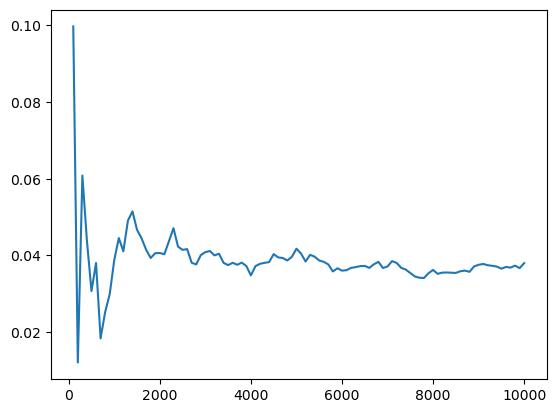

In [30]:
def convergence_rate_M(): 
    res = []  
    m_space =np.linspace(100, 10000, 100)
    X = monte_carlo(a, b, T, T/1000, 1, 10000)
    for m in m_space:
        EX = np.mean(X[:int(m),:], axis=0)[-1]
        res.append(np.abs(EX - expectation(T, 1, a)))
    plt.plot(m_space, res)

convergence_rate_M()

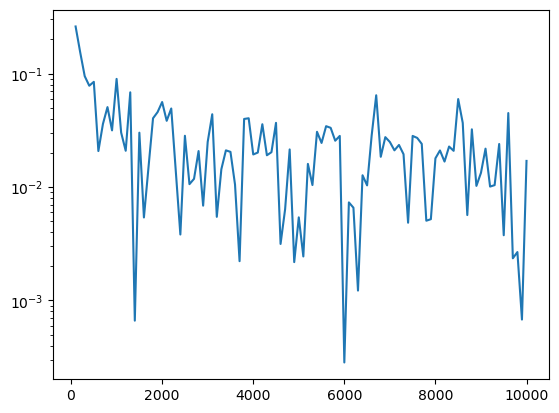

In [31]:
@cache
def convergence_rate_N(): 
    res = []  
    n_space =np.linspace(100, 10000, 100)
    for n in n_space:
        X = monte_carlo(a, b, T, T/int(n), 1, 1000)
        EX = np.mean(X, axis=0)[-1]
        res.append(np.abs(EX - expectation(T, 1, a)))
    plt.yscale('log')
    plt.plot(n_space, res)

convergence_rate_N()